<a href="https://colab.research.google.com/github/zlximon/Tensorflow_DL/blob/master/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#downloading helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


--2022-06-07 16:38:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-07 16:38:07 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
dataset_list=tfds.list_builders()# lits of all tensorflos datasets


tensorflow datasets , are in tensors ready to work with

In [ ]:
(train_data,test_data),ds_info=tfds.load("food101",split=["train","validation"],
                                         shuffle_files=True,as_supervised=True,#out data gets returned in tuple format(data,label) for supervised learning  
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete5PBA0S/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete5PBA0S/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
class_names=ds_info.features["label"].names# class names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_sample=train_data.take(1)
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image,label in train_sample:
   print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 384, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 19
  Class name (str form): chicken_quesadilla
  


In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'chicken_quesadilla')

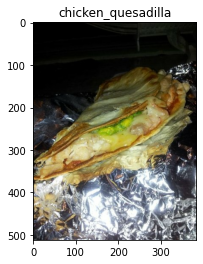

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list


In [ ]:
def preprocess_img(image,label,img_shape=224):
  """
  converts image datatype from unit8 to float 32 and reshape image 
  """
  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label

In [ ]:
preproccesed=preprocess_img(image,label)[0]
print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 19
  Class name (str form): chicken_quesadilla
        


#batch and prepare datasets

In [ ]:
#map preprocessing for training data
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)#use most of cpu for execute  
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
#map preprocessing for test data
test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

#creating modelling callback

In [ ]:
#create tensorboard 
from helper_functions import create_tensorboard_callback

checkpoint_patch="model_checkpoins/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_patch,monitor="val_acc",save_best_only=True,save_weights_only=True,verbose=0)

#setup mixed precision training




In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")#set global data policy to mixed precision its speeding up our code so much
# the improvement are much noticable on larger models 

#build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
input_shape=(224,224,3)
#create base model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False 
#create model
inputs=layers.Input(shape=input_shape ,name="input_layers")
# in EfficientNetB0 Model we dont need rescaling 
x=base_model(inputs,training=False) 
x=layers.GlobalAveragePooling2D()(x)
x= layers.Dense(len(class_names))(x)# number of outputs 
outputs=layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])# out labels are in int form

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layers True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_3 True float32 <Policy "mixed_float16">
dense_3 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

In [ ]:
#fit the model
history = model.fit(train_data,epochs=3,steps_per_epoch=(len(train_data)),validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                       experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220607-180435
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.4488 - accuracy: 0.6302WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 173s 72ms/step - loss: 1.4488 - accuracy: 0.6302 - val_loss: 1.1663 - val_accuracy: 0.6896
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2177 - accuracy: 0.6855WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 175s 73ms/step - loss: 1.2177 - accuracy: 0.6855 - val_loss: 1.1022 - val_accuracy: 0.7050
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.7140WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 161s 67ms/step - loss: 1.0967 - accuracy: 0.7140 - val_loss: 1.0712 - val_accuracy: 0.7023


In [ ]:
result_feature=model.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.0807 - accuracy: 0.7091
